# 1. Player Performance Quatification

---

### Importing Required Libraries

In [1]:
import numpy as np                                                       # linear algebra
import pandas as pd                                                      # data processing, CSV file I/O
import matplotlib.pyplot as plt                                          # Data Visualization 
import seaborn as sns                                                    # Python library for Visualization
from sklearn import preprocessing                                        # Library for data pre-processing
from sklearn.model_selection import train_test_split                     # To split dataset into training and testing
from sklearn.cluster import KMeans                                       # K-Means clustering model
from sklearn.neighbors import KNeighborsClassifier                       # KNN-Classification model
from sklearn.metrics import accuracy_score                               # Library to calculate accuracy of a model

max = 9223372036854775807


### Defining Functions To Evaluate Batting Performance


In [2]:
# defining calculation functions

def calcBA(pruns, pinnings, pnotout):
    ba = pruns / (pinnings - pnotout)
    return ba


def calcBS(pruns, pbfaced):
    bs = pruns / pbfaced
    return bs


def calcMRA(pinnings, pnotout, pbfaced):
    mra = (pinnings - pnotout) / pbfaced
    return mra


def calcBRPI(pfours, psixes, pinnings):
    brpi = (4*pfours + 6*psixes) / pinnings
    return brpi


def calcBatOutRate(pinnings, pnotout, pbfaced):
    outrate = pd.Series(np.array([max])) if float(pbfaced) == 0 else (pinnings - pnotout) / pbfaced
    return outrate

#         BA = calcBA(p['runs'], p['innings'], p['not_out'])
#         BS = calcBS(p['runs'], p['ball_faced'])
#         MRA = calcMRA(p['innings'], p['not_out'], p['ball_faced'])
#         BRPI = calcBRPI(p['fours'], p['sixes'], p['innings'])


def calcGenBatAvg(truns, twickets):
    return truns / twickets


def calcGenBatOutRate(twickets, tbfaced):
    return twickets / tbfaced


def calcGenStrikeRate(truns, tbfaced):
    return truns / tbfaced


def calcBatAGR(tpRuns, tpBallfaced, tpOutRate, gBatAvg, gStrikeRate, gOutRate):
    agr = ((tpRuns - gStrikeRate * tpBallfaced) + gBatAvg * tpBallfaced * (gOutRate - tpOutRate))
#     d = np.array([132])
#     tm = pd.Series(np.array([0]))
    return agr


def calcBatRankingIndex(agr, gBatAvg):
    return agr / (10 * gBatAvg)



### Defining Functions To Evaluate Bowling Performance

In [3]:

def calcBowlAvg(runsGiven, wicketsTaken):
    return runsGiven / wicketsTaken


def calcBowlSR(ballsBowled, wicketsTaken):
    return ballsBowled / wicketsTaken


def calcBowlER(runsGiven, oversBowled):
    return runsGiven / oversBowled


def calcBowlOutRate(wicketsTaken, ballsBowled):
    outr = pd.Series(np.array([0])) if float(ballsBowled) == 0 else wicketsTaken / ballsBowled
    return outr



### Defining Functions To Calculate Generic Tournament Parameters

In [4]:
# generic tournament parameters

def calcGenBowlAvg(totalRunsGiven, totalWicketsTaken):
    return totalRunsGiven / totalWicketsTaken


def calcGenBowlOutRate(totalWicketsTaken, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return totalWicketsTaken / balls


def calcGenBowlSR(totalRunsGiven, totalOvers):
    balls = int(totalOvers) * 6 + 10 * (totalOvers - int(totalOvers))
    return  totalRunsGiven / balls


def calcBowlAGR(tpRunsGiven, tpOvers, tpOutrate, gBowlAvg, gBowlSR, gBowlOutrate ):
    balls = int(tpOvers) * 6 + 10 * (tpOvers - int(tpOvers))
    bowlagr = (gBowlSR * balls - tpRunsGiven) + gBowlAvg * balls * (tpOutrate - gBowlOutrate)
    
#     print(bowlagr[0])
#     if tpOvers[0] == 0.1:
#         print('-------------------------------')
#         print('tpRunsGiven  :',tpRunsGiven[0]) 
#         print('tpballs      :', balls[0])
#         print('tpOutrate    :', tpOutrate[0])
#         print('gBowlAvg     :', gBowlAvg[0]) 
#         print('gBowlSR      :', gBowlSR[0])
#         print('gBowlOutrate :',  gBowlOutrate[0])
#         print('-------------------------------')
#         print('bowlAGR      : ', bowlagr)
        
    return bowlagr


def calcBowlRI(bowlAGR, gBowlAvg):
    bri = bowlAGR / (10 * gBowlAvg)
    
#     if bri[0] == 0:
#         print('-------------------------------')
#         print('bowlagr  : ', bowlAGR[0] )
#         print('gbowlAvg : ', gBowlAvg[0])
#         print('-------------------------------')
    
    return bowlAGR / (10 * gBowlAvg)

### Defining Function To Claculate Series-wise Batting and Bowling Indexes for All Players 

In [5]:
def calcIndexes(srec):

    series = list(dict.fromkeys(srec["series_code"]).keys())

    # trecord : dataframe for tournament overall performance
    # precord : dataframe for player specific performance in tournament
    # tplayer: dataframe for recording total runs, ballfaced etc for player

    trecord = pd.DataFrame()
    precord = pd.DataFrame()
    tplayer = pd.DataFrame()
    pindexes = pd.DataFrame()

    tournamentPerformance = dict()

    for sr in series[:]:
        tdf = srec[srec["series_code"] == sr]

        ttotal = tdf.drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

        ttotal = pd.DataFrame(ttotal.sum(axis = 0))
        ttotal = ttotal.swapaxes('index', 'columns')
        ttotal.insert(0, 'series_code', value = sr)

        gBatAvg = calcGenBatAvg(ttotal['runs'], ttotal['wickets_taken'])
        gBatOutRate = calcGenBatOutRate(ttotal['wickets_taken'], ttotal['ballfaced'])
        gStrikeRate = calcGenStrikeRate(ttotal['runs'], ttotal['ballfaced'])

        gBowlAvg = calcBowlAvg(ttotal['runs_given'], ttotal['wickets_taken'])
        gBowlOutrate = calcGenBowlOutRate(ttotal['wickets_taken'], ttotal['overs'])
        gBowlSR = calcGenBowlSR(ttotal['runs_given'], ttotal['overs'])

#         tp = {
#             'series_code' : sr, 
#             'gBatAvg'     : gBatAvg[0], 
#             'gBatOutRate' : gBatOutRate[0], 
#             'gStrikeRate' : gStrikeRate[0],
#             'gBowlAvg'    : gBowlAvg[0], 
#             'gBowlOutrate' : gBowlOutrate[0], 
#             'gBowlSR'     : gBowlSR[0]
#         }

#         trecord = trecord.append(tp, ignore_index=True)

        players = list()
        for pl in set(tdf["pid"]):
            if pl > 0:
                players.append(pl)

        for player in players[:]:


            ptdf = tdf[tdf['pid'] == player].drop(['series_code', 'match_code', 'pid', 'name'], axis = 1)

            pinnings = len(ptdf)
            p = pd.DataFrame(ptdf.sum(axis = 0))
            p = p.swapaxes('index', 'columns')

            tplayer = tplayer.append(p)

            batOutRate = calcBatOutRate(pinnings, p['notout'], p['ballfaced'])
            bowlOutRate = calcBowlOutRate(p['wickets_taken'], p['overs'])

            batAGR = calcBatAGR(p['runs'], p['ballfaced'], batOutRate, gBatAvg, gStrikeRate, gBatOutRate)
            batRI = calcBatRankingIndex(batAGR, gBatAvg)

            bowlAGR = calcBowlAGR(p['runs_given'], p['overs'], bowlOutRate, gBowlAvg, gBowlSR, gBowlOutrate)
            bowlRI = calcBowlRI(bowlAGR, gBowlAvg)

            pRI = {
                'series_code' : sr,
                'pid'    : player,
#                 'batAGR' : batAGR[0],
                'batRI'  : batRI[0],
#                 'bowlAGR': bowlAGR[0],
                'bowlRI' : bowlRI[0]
            }

            pindexes = pindexes.append(pRI, ignore_index = True)
    
    return pindexes


### Defining Function To Claculate **Average** of Series-wise Batting and Bowling Indexes for All Players 

In [6]:
def calcAvgRI(data):
    rdata = pd.DataFrame()
    for player in set(data.pid):
        p= data[data['pid'] == player]
        ser = len(p)
        p = p.drop(['pid', 'series_code'], axis = 1 )
        p = pd.DataFrame(p.mean(axis = 0))
        p = p.swapaxes('index', 'columns')

        p.insert(0, 'pid', player)
        p.insert(0, 'series_played', ser)
        rdata = rdata.append(p)
        rdata = rdata.reset_index(drop = True)
    return rdata

### Defining function to return top n batting and bowling indexes

In [7]:
def getMaxIndexes(idata, n):
    ret = pd.DataFrame()
    
    tmp = idata.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    ret['MaxBatRI'] = tmp['batRI']
    
    tmp = idata.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    ret['MaxBowlRI'] = tmp['bowlRI']
    
    return ret.head(n)

*******

## 1.1 RI Calculation For International Team Players

### Imporing player record from csv file

In [8]:
iplayers = pd.read_csv("serieswiseMatchRecord.csv")
iplayers.head(5)

,series_code,match_code,pcid,pcountry,pid,name,notout,runs,ballfaced,fours,sixes,overs,maiden_overs,runs_given,wickets_taken
0,191,1892,7,Pakistan,-7,Extras,0,11,0,0,0,0.0,0,0,0
1,191,1892,7,Pakistan,29,Wasim Akram,1,13,24,1,0,8.3,0,46,1
2,191,1892,7,Pakistan,986,Rashid Latif,0,47,58,4,0,0.0,0,0,0
3,191,1892,7,Pakistan,1794,Inzamam-ul-Haq,0,1,20,0,0,0.0,0,0,0
4,191,1892,7,Pakistan,1959,Waqar Younis,0,0,0,0,0,8.0,1,37,1


In [9]:
iplayers['ballfaced'].replace({0 : 1}, inplace=True)
iplayers['overs'].replace({0.0 : 0.1}, inplace=True)

### Caluculating series-wise ranking indexes

In [10]:
ipIndexes = calcIndexes(iplayers)
ipIndexes.head()

,batRI,bowlRI,pid,series_code
0,-0.206716,0.000000,1794.0,191.0
1,-0.177612,0.179796,2180.0,191.0
2,0.120896,2.702037,2191.0,191.0
3,0.411940,1.968336,791.0,191.0
4,0.048507,0.438736,29.0,191.0


### Calculating average ranking indexes

In [11]:
aipIndexes = calcAvgRI(ipIndexes)
aipIndexes.head()

,series_played,pid,batRI,bowlRI
0,15,3.0,0.076147,0.180482
1,1,6.0,-0.123684,0.349038
2,5,9.0,-0.042231,0.464153
3,1,12.0,-0.200000,1.647188
4,1,13.0,-0.100000,-0.074398


### Looking for max index values

In [12]:
getMaxIndexes(aipIndexes, 5)

,MaxBatRI,MaxBowlRI
0,0.397787,8.354687
1,0.329958,7.528259
2,0.272858,7.342466
3,0.252941,5.930167
4,0.249999,5.375342


---

## 1.2 RI Calculation For State Team Player

### Importing players record from csv file

In [13]:
splayers = pd.read_csv("newPlayers.csv")
splayers.head(5)

,series_code,match_code,team,pid,name,notout,runs,ballfaced,fours,sixes,overs,maiden_overs,runs_given,wickets_taken
0,2364,15146,Vidarbha,574,S Badrinath,0,0,11,0,0,0.0,0,0,0
1,2364,15146,Vidarbha,1596,Faiz Fazal,0,15,22,1,1,0.0,0,0,0
2,2364,15146,Vidarbha,2215,Ganesh Satish,0,5,7,1,0,0.0,0,0,0
3,2364,15146,Vidarbha,6286,Shrikant Wagh,0,0,1,0,0,10.0,0,47,0
4,2364,15146,Vidarbha,8949,Akshay Wakhare,0,0,2,0,0,10.0,1,41,1


In [14]:
splayers['ballfaced'].replace({0 : 1}, inplace=True)
splayers['overs'].replace({0.0 : 0.1}, inplace=True)

### Caluculating series-wise ranking indexes

In [15]:
spIndexes = calcIndexes(splayers)
spIndexes.head()

,batRI,bowlRI,pid,series_code
0,0.706041,0.840575,8198.0,2364.0
1,-0.285579,1.190705,10249.0,2364.0
2,0.229969,0.000000,10250.0,2364.0
3,-0.377422,1.657774,10251.0,2364.0
4,-0.218792,2.625313,8204.0,2364.0


### Calculating average ranking indexes

In [16]:
aspIndexes = calcAvgRI(spIndexes)
aspIndexes.head()

,series_played,pid,batRI,bowlRI
0,1,14336.0,-0.200000,1.538407e+00
1,1,10242.0,-0.284535,2.558209e+00
2,1,14338.0,-0.100000,-3.888457e-19
3,1,14339.0,-0.100000,-8.405786e-02
4,5,8198.0,0.313981,2.321787e+00


### Looking for max index values

In [17]:
getMaxIndexes(aspIndexes, 5)

,MaxBatRI,MaxBowlRI
0,1.331807,12.030585
1,1.113433,11.234500
2,0.748413,10.674472
3,0.689110,9.624982
4,0.662747,9.126766


---

# 2. Clustering of Players

---

## 2.1 Cluster analysis for International Team Players

### Plotting original Batting and Bowling indexes of all players

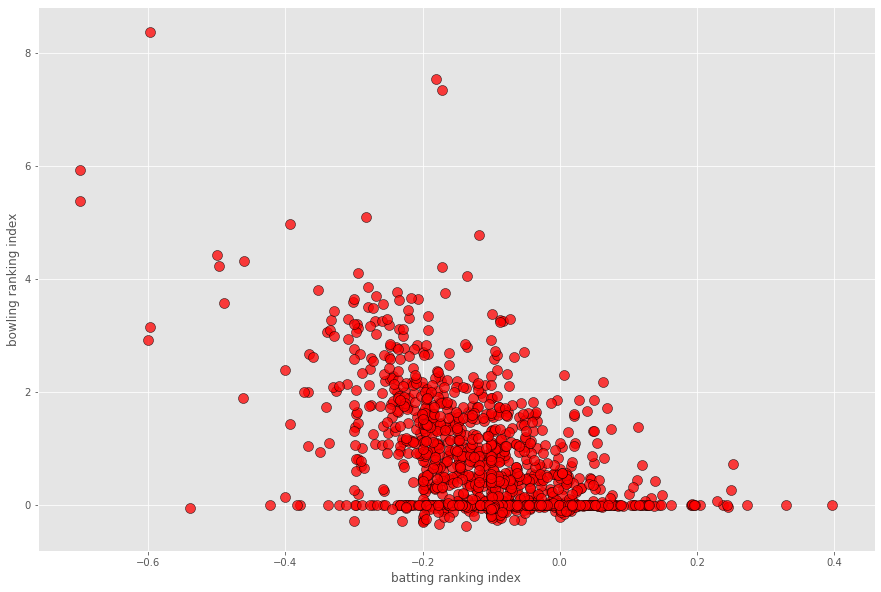

In [18]:
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.style.use('ggplot')
plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, s = 100, c = 'red', edgecolor = 'black', linewidth = .6, alpha = .75)
plt.xlabel('batting ranking index')
plt.ylabel('bowling ranking index')

plt.show()

### Applying K-Means Clustering with 5-neighbours on players indexes

In [19]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(aipIndexes[['batRI', 'bowlRI']])
aipIndexes['clusterRI'] = kmeans.predict(aipIndexes[['batRI', 'bowlRI']])

### Plotting Clustered Batting and Bowling indexes of all players

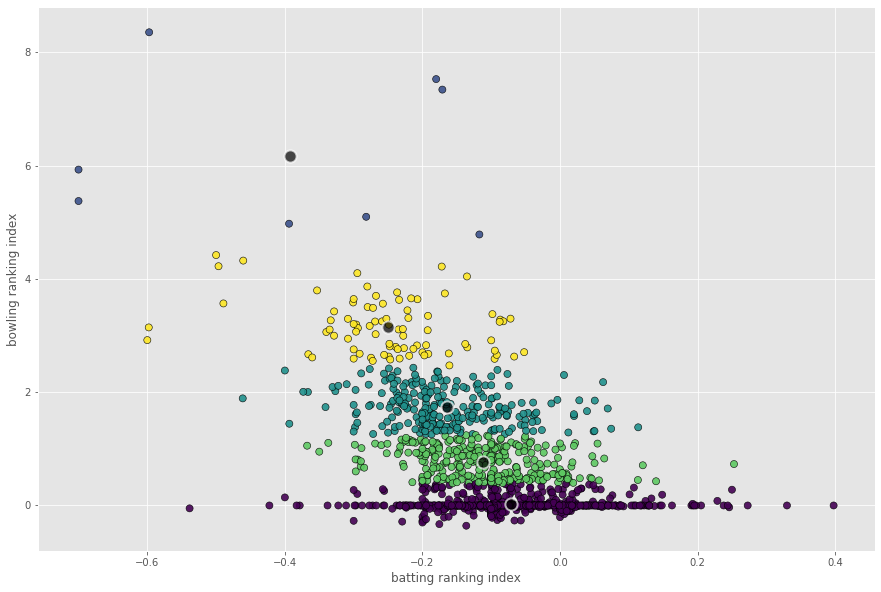

In [20]:
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.scatter(aipIndexes.batRI, aipIndexes.bowlRI, c = aipIndexes['clusterRI'] , s=50 ,edgecolor = 'black',
            linewidth = .6 ,alpha = .9)

plt.xlabel('batting ranking index')
plt.ylabel('bowling ranking index')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', edgecolor = 'white', linewidth = 2, s=150, alpha=.7);

plt.show()

### Displaying sample output of clustering

In [21]:
aipIndexes.head()

,series_played,pid,batRI,bowlRI,clusterRI
0,15,3.0,0.076147,0.180482,0
1,1,6.0,-0.123684,0.349038,0
2,5,9.0,-0.042231,0.464153,3
3,1,12.0,-0.200000,1.647188,2
4,1,13.0,-0.100000,-0.074398,0


---

## 2.2 Cluster analysis for State Team Players

### Defining functions for index range manipulations

In [22]:
def weight_alpha(pindexes, a):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    for i in range(len(x1)):
        if(x1[i]>=0):
            x1[i]=x1[i]*(a/100)
        else:
            x1[i]=x1[i]+(x1[i]*((100-a)/100))
    for j in range(len(y1)):
        if(y1[j]>=0):
            y1[j]=y1[j]*(a/100)
        else:
            y1[j]=y1[j]+(y1[j]*((100-a)/100))
            

def modify(pindexes, mul):
    
    x1 = pindexes['batRI'].values
    y1 = pindexes['bowlRI'].values
    
    for i in range(len(x1)):
        x1[i]=x1[i]*mul
        y1[i]=y1[i]*mul


### Increasing range of indexes to thousand times

In [23]:
ctrain = aipIndexes.copy()
modify(ctrain, 1000)
ctrain.head()

,series_played,pid,batRI,bowlRI,clusterRI
0,15,3.0,76.146666,180.482185,0
1,1,6.0,-123.684211,349.038462,0
2,5,9.0,-42.231365,464.153475,3
3,1,12.0,-200.000000,1647.188139,2
4,1,13.0,-100.000000,-74.397798,0


### Splitting data into input feature 'x' and output feature 'y'

In [24]:
x = ctrain.iloc[:,-3:-1].values
x = preprocessing.normalize(x)
x = preprocessing.scale(x)

y = ctrain.iloc[:,-1].values

### Applying KNN-Classifier taking 70% as training data

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

clf = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree')
clf.fit(x_train,y_train)

print("Model Trained")

Model Trained


### Calculating accuracy of the model

In [49]:
y_pred3 = clf.predict(x_test)
acc3 =   accuracy_score(y_test,y_pred3)
print("Accuracy Score: ", acc3 * 100, "%")

Accuracy Score:  74.01960784313727 %


### Calculating ODI considerable performance of State Level players 

In [50]:
waspIndexes = aspIndexes.copy()
weight_alpha(waspIndexes,.1)

spred = waspIndexes.copy()
modify(spred,1000)
spred.head()  
# aspIndexes.head()

,series_played,pid,batRI,bowlRI
0,1,14336.0,-399.800000,1.538407e+00
1,1,10242.0,-568.785072,2.558209e+00
2,1,14338.0,-199.900000,-7.773026e-16
3,1,14339.0,-199.900000,-1.680317e+02
4,5,8198.0,0.313981,2.321787e+00


### Looking for max index values

In [51]:
getMaxIndexes(waspIndexes, 5)

,MaxBatRI,MaxBowlRI
0,0.001332,0.012031
1,0.001113,0.011234
2,0.000748,0.010674
3,0.000689,0.009625
4,0.000663,0.009127


### Prepairing input for model

In [52]:
spredInp = spred[['batRI', 'bowlRI']].values
spredInp = preprocessing.normalize(spredInp)
spredInp = preprocessing.scale(spredInp)

### Predicting cluster for state level players

In [53]:
waspIndexes["clusterRI"] = clf.predict(spredInp)
waspIndexes.head()
getMaxIndexes(waspIndexes, 5)

,MaxBatRI,MaxBowlRI
0,0.001332,0.012031
1,0.001113,0.011234
2,0.000748,0.010674
3,0.000689,0.009625
4,0.000663,0.009127


---

# 3. Team Structure Analysis

---

### Defining function to select players

In [54]:
def selectPlayers(pclustered, team, nbats, nbowls, nall):
    pospl = pd.DataFrame()
    
    total_players = nbats + nbowls + nall
    rankbat = list()
    rankbowl = list()
    
    pteam = pclustered[pclustered.cid == team]
    
    lpteam = len(pteam)
    print("lpteam:", lpteam)
    
    if lpteam < total_players:
        print("ERROR: Avaliable players {} is less than required {}".format(lpteam, total_players))
        return None
    
    ptbat = pteam[(pteam.clusterRI == 0) | (pteam.clusterRI == 1)]
    ptbat = ptbat.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    lbat = len(ptbat)
#     print("bats: ", ptbat)
    
    ptbowl = pteam[pteam.clusterRI == 4]    
    ptbowl = ptbowl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    lbowl = len(ptbowl)
#     print("ptbowls: ", ptbowl)
    
    ptall = pteam[(pteam.clusterRI == 2) | (pteam.clusterRI == 3)]
    ptall.insert(2, 'rir', ptall.batRI/ptall.bowlRI)
    lall = len(ptall)
#     print("ptall: ", ptall)
    
    if lbat < nbats:
        nall = nall + (nbats - lbat)
        nbats = lbat
        
    if lbowl < nbowls:
        nall = nall + (nbowls - lbowl)
        nbowls = lbowl
    
    if lall < nall:
        nbats = nbats + (nall - lall)
        nall = lall
        
    mp = {
        'batsman' : nbats,
        'bowlers': nbowls,
        'allrounders' : nall
    }
    print("Selecting: ", mp)
    
    ptall = ptall.sort_values(['rir', 'batRI','bowlRI'], ascending = False).reset_index(drop=True)
    
    for i in range(0, nbats):
        pospl = pospl.append(ptbat.iloc[i])
    

    for b in range(0, nbowls):
        pospl = pospl.append(ptbowl.iloc[b])
        
    l = len(pospl)
    for b in range(0, nall):
        pospl = pospl.append(ptall.iloc[b])
        
    print("tplayers: ", pospl.shape)
        
#     batting ranking

    batpl = pospl.sort_values(['batRI'], ascending=False).reset_index(drop=True)
    
    
    for b in range(0, total_players):
        rankbat.append((b+1, [batpl.iloc[b]['name'], batpl.iloc[b]['team']]))
        
#     bowling ranking

    bowlpl = pospl.sort_values(['bowlRI'], ascending=False).reset_index(drop=True)
    
    for b in range(0, total_players):
        rankbowl.append((b+1, [bowlpl.iloc[b]['name'], bowlpl.iloc[b]['team']]))
        
    return (rankbat, rankbowl)
        
    
# selectPlayers(aplayers, team=5, nbats = 5, nbowls = 5, nall = 5)[0]

### Importing players personal information

In [55]:
ipinfo = pd.read_csv('playerList.csv')
spinfo = pd.read_csv('newPlayerList.csv')

### Merging players personal info with their respective performance

In [56]:
iplayers = pd.DataFrame.merge(ipinfo, aipIndexes, on='pid', how='inner')
iplayers.insert(3, 'team', value='ODI')
iplayers.head()

,pid,name,yob,team,cid,iscurrent,series_played,batRI,bowlRI,clusterRI
0,2255,M N Samuels,1981,ODI,10,1,12,-0.000226,6.394588e-01,3
1,2977,H Masakadza,1983,ODI,11,1,9,-0.134686,1.051152e-01,0
2,2995,Mashrafe Mortaza,1983,ODI,3,1,7,-0.119307,1.741568e+00,2
3,3035,P A Patel,1985,ODI,5,1,7,-0.071118,4.500601e-19,0
4,3065,J M Anderson,1982,ODI,4,1,9,-0.293833,3.132003e+00,4


In [57]:
splayers = pd.DataFrame.merge(spinfo, waspIndexes, on='pid', how='inner')
splayers.insert(4, 'cid', value=5)
splayers.tail()

,pid,name,yob,team,cid,iscurrent,series_played,batRI,bowlRI,clusterRI
1142,15650,Sandeep Yadav,1998,Railways,5,1,1,-0.305349,-1.554605e-18,0
1143,15651,Tanush Gusain,1998,UTTARAKHAND,5,1,1,-0.239960,-1.554605e-18,0
1144,15652,Temjentoshi,1998,NAGALAND,5,1,1,-0.080121,-1.554605e-18,0
1145,15653,WL Kynshi,1998,MEGHALAYA,5,1,1,-0.199900,-7.773026e-19,0
1146,15656,Vijay Singh,1998,Delhi,5,1,1,0.000000,5.229470e-04,0


### Merging both players data together to form dataset of all players

In [58]:
aplayers = iplayers.append(splayers, sort=True).reset_index(drop=True)
aplayers.head(5)

,batRI,bowlRI,cid,clusterRI,iscurrent,name,pid,series_played,team,yob
0,-0.000226,6.394588e-01,10,3,1,M N Samuels,2255,12,ODI,1981
1,-0.134686,1.051152e-01,11,0,1,H Masakadza,2977,9,ODI,1983
2,-0.119307,1.741568e+00,3,2,1,Mashrafe Mortaza,2995,7,ODI,1983
3,-0.071118,4.500601e-19,5,0,1,P A Patel,3035,7,ODI,1985
4,-0.293833,3.132003e+00,4,4,1,J M Anderson,3065,9,ODI,1982


### Extracting players of a country (INDIA)

In [59]:
for_country = 5
caplayers = aplayers[aplayers['cid']  == for_country]

### Selection of players

In [60]:
ranking = selectPlayers(aplayers, team=5, nbats = 5, nbowls = 5, nall = 10)

if ranking is not None:
    print('BATSMAN RANKING')
    print('----------------------------------------------------')
    for pl in ranking[0]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])

    print()
    print('BOWLER RANKING') 
    print('----------------------------------------------------')
    for pl in ranking[1]:
        print('POSITION: ', "{:>2}: ".format(pl[0]), "{:<20}".format(pl[1][0]), "{:>10}".format("team: "), pl[1][1])
  
# ranking[1]

lpteam: 1194
Selecting:  {'batsman': 5, 'bowlers': 5, 'allrounders': 10}
tplayers:  (20, 11)
BATSMAN RANKING
----------------------------------------------------
POSITION:   1:  V Kohli                  team:  ODI
POSITION:   2:  A T Rayudu               team:  ODI
POSITION:   3:  R G Sharma               team:  ODI
POSITION:   4:  M S Dhoni                team:  ODI
POSITION:   5:  S S Iyer                 team:  ODI
POSITION:   6:  J Yadav                  team:  ODI
POSITION:   7:  Prashant Chopra          team:  Himachal Pradesh
POSITION:   8:  Yashpal Singh            team:  Services
POSITION:   9:  Atharva taide            team:  Vidarbha
POSITION:  10:  Kedar Jadhav             team:  Maharashtra
POSITION:  11:  Sachin Baby              team:  Kerala
POSITION:  12:  Tilak Varma              team:  Hyderabad
POSITION:  13:  Bravish Shetty           team:  Tripura
POSITION:  14:  Swarupam Purkayastha     team:  Assam
POSITION:  15:  Prasanth Kumar           team:  Andhra
POSITION: